## Project

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [ ]:
df = pd.read_csv('../data/raw/hillstrom.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


## 1 — EDA & baseline metrics

In [125]:
cr_by_visit = (df.groupby('segment')['visit'].apply(lambda s: (s==1).mean()).sort_index())
ctrl = cr_by_visit['No E-Mail']
delta_visit = (cr_by_visit - ctrl)
result_visit_cr = (pd.DataFrame({
    'CR_visit': (cr_by_visit * 100).round(2),                  # CR, %
    'CR_delta_visit': (delta_visit * 100).round(2)    # дельта к контролю, процентные пункты
}))
result_visit_cr

,CR_visit,CR_delta_visit
segment,,
Mens E-Mail,18.28,7.66
No E-Mail,10.62,0.00
Womens E-Mail,15.14,4.52


In [126]:
cr_by_conversion = (df.groupby('segment')['conversion'].apply(lambda s: (s==1).mean()).sort_index())
ctrl_conv = cr_by_conversion['No E-Mail']
delta_conv = (cr_by_conversion - ctrl_conv)
result_conv_cr = (pd.DataFrame({
    'CR_conv': (cr_by_conversion * 100).round(2),                  # CR, %
    'CR_delta_conv': (delta_conv * 100).round(2)    # дельта к контролю, процентные пункты
}))
result_conv_cr

,CR_conv,CR_delta_conv
segment,,
Mens E-Mail,1.25,0.68
No E-Mail,0.57,0.00
Womens E-Mail,0.88,0.31


In [ ]:
arpu = df.groupby('segment')['spend'].mean()
ctrl_arpu = arpu['No E-Mail']
delta_arpu = (arpu - ctrl_arpu)
result_arpu = pd.DataFrame({
    'ARPU': arpu.round(2),
    'Δ_ARPU': delta_arpu.round(2)
    })
result_arpu

,ARPU,Δ_ARPU
segment,,
Mens E-Mail,1.42,0.77
No E-Mail,0.65,0.00
Womens E-Mail,1.08,0.42


In [ ]:
result_by_cv_arpu = pd.concat([result_visit_cr, result_conv_cr, result_arpu], axis=1)
result_by_cv_arpu

,CR_visit,Δ_CR_visit_vs_control_pp,CR_conv,Δ_CR__conv_vs_control_pp,ARPU,Δ_ARPU
segment,,,,,,
Mens E-Mail,18.28,7.66,1.25,0.68,1.42,0.77
No E-Mail,10.62,0.00,0.57,0.00,0.65,0.00
Womens E-Mail,15.14,4.52,0.88,0.31,1.08,0.42


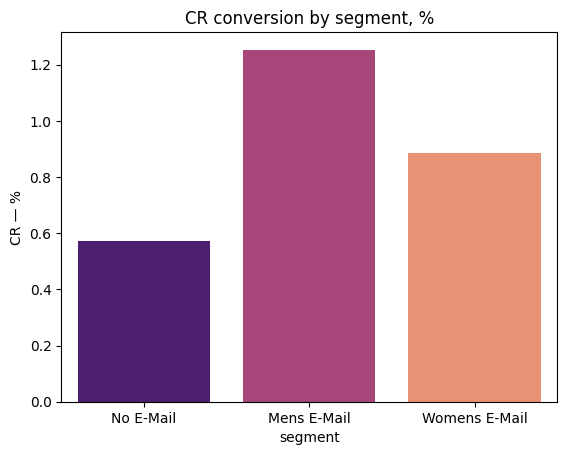

In [170]:
cr_conv_pct = (cr_by_conversion * 100).reindex(["No E-Mail", "Mens E-Mail", "Womens E-Mail"])
sns.barplot(x=cr_conv_pct.index, y=cr_conv_pct.values, hue=cr_conv_pct.index, legend=False, palette='magma')
plt.title('CR conversion by segment, %')
plt.ylabel('CR — %')
plt.savefig("../reports/figures/cr_conv_by_segment.png", dpi=200)

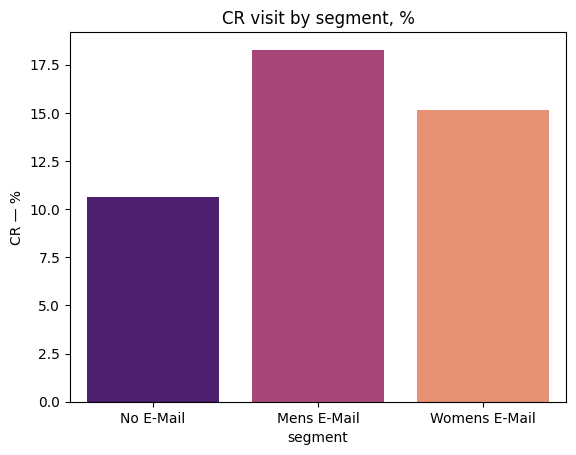

In [171]:
cr_visit_pct = (cr_by_visit * 100).reindex(["No E-Mail", "Mens E-Mail", "Womens E-Mail"])
sns.barplot(x=cr_visit_pct.index, y=cr_visit_pct.values, hue=cr_visit_pct.index, legend=False, palette='magma')
plt.title('CR visit by segment, %')
plt.ylabel('CR — %')
plt.savefig("../reports/figures/cr_visit_by_segment.png", dpi=200)

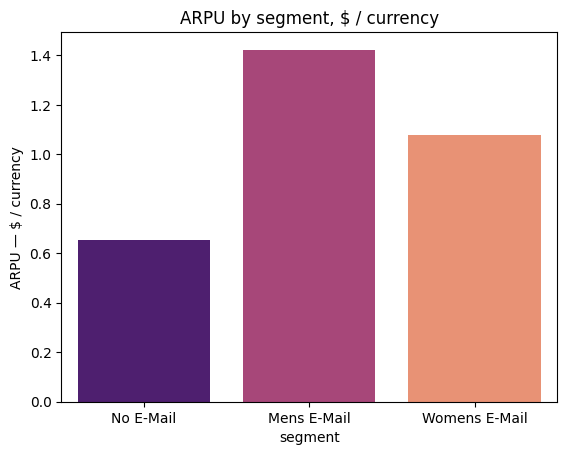

In [172]:
arpu_pct = arpu.reindex(["No E-Mail", "Mens E-Mail", "Womens E-Mail"])
sns.barplot(x=arpu_pct.index, y=arpu_pct.values, hue=arpu_pct.index, legend=False, palette='magma')
plt.title('ARPU by segment, $ / currency')
plt.ylabel('ARPU — $ / currency')
plt.savefig("../reports/figures/arpu_by_segment.png", dpi=200)

## Findings
- Goal: boost purchases and revenue. Primary metrics: CR_conv and ARPU.
- Control (No E-Mail): CR_conv = 0.57%, ARPU = 0.65.
- Mens E-Mail: CR_conv = 1.25% (**+0.68 p.p.** vs control), ARPU = 1.42 (**+0.77**).
- Womens E-Mail: CR_conv = 0.88% (**+0.31 p.p.** vs control), ARPU = 1.08 (**+0.42**).
**Conclusion:** Email increases both conversion and revenue; Mens outperforms Womens on average.


In [90]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [162]:
def CI(n, n_ctrl, cr, cr_ctrl, alpha=0.05):
    z = 1.96 if alpha == 0.05 else 1.96 # добавить для разных квантилей
    p_m, p_c = cr, cr_ctrl
    n_m, n_c = n, n_ctrl
    SE = ((p_m*(1-p_m)/n_m) + (p_c*(1-p_c)/n_c))**0.5
    delta = p_m - p_c
    lo = delta - z*SE
    hi = delta + z*SE
    result = {
        "delta_pp": round(delta*100, 4),    # точечная оценка
        "ci_lo_pp": round(lo*100, 4),       # нижняя граница
        "ci_hi_pp": round(hi*100, 4),       # верхняя граница
        "significant": lo > 0 or hi < 0     # интервал не пересекает 0
    }

    sign = "значимо" if result["significant"] else "не значимо"
    print(f"ΔCR = {result['delta_pp']:.3f} pp; 95% CI [{result['ci_lo_pp']:.3f}; {result['ci_hi_pp']:.3f}] — {sign}")
    return result

In [163]:
n_total = df.groupby('segment').size()
CI_mens = CI(n_total['Mens E-Mail'], n_total['No E-Mail'], cr_by_conversion['Mens E-Mail'], cr_by_conversion['No E-Mail'])
CI_womens = CI(n_total['Womens E-Mail'], n_total['No E-Mail'], cr_by_conversion['Womens E-Mail'], cr_by_conversion['No E-Mail'])
summary_ci = (pd.DataFrame([CI_mens, CI_womens],
                           index=["Mens E-Mail", "Womens E-Mail"]))
summary_ci


ΔCR = 0.680 pp; 95% CI [0.500; 0.861] — значимо
ΔCR = 0.311 pp; 95% CI [0.150; 0.472] — значимо


,delta_pp,ci_lo_pp,ci_hi_pp,significant
Mens E-Mail,0.6805,0.5000,0.8610,True
Womens E-Mail,0.3111,0.1499,0.4723,True


In [164]:
agg = df.groupby("segment")["spend"].agg(n="count", mean="mean", var="var")

def CI_Welch(n1, n0, m1, m0, s1_sq, s0_sq, alpha=0.05):
    z = 1.96 if alpha == 0.05 else 1.96
    delta = m1 - m0
    se = ((s1_sq / n1) + (s0_sq / n0)) ** 0.5
    lo, hi = delta - z*se, delta + z*se
    res = {
        "delta": round(delta, 4),
        "ci_lo": round(lo, 4),
        "ci_hi": round(hi, 4),
        "significant": (lo > 0) or (hi < 0)
    }
    print(f"ΔARPU = {res['delta']:.3f} (currency); 95% CI [{res['ci_lo']:.3f}; {res['ci_hi']:.3f}] — "
          f"{'значимо' if res['significant'] else 'не значимо'}")
    return res

In [165]:
n_m, m_m, v_m = agg.loc["Mens E-Mail", ["n","mean","var"]]
n_c, m_c, v_c = agg.loc["No E-Mail",  ["n","mean","var"]]
n_w, m_w, v_w = agg.loc["Womens E-Mail", ["n","mean","var"]]

mens_vs_ctrl   = CI_Welch(n_m, n_c, m_m, m_c, v_m, v_c)
womens_vs_ctrl = CI_Welch(n_w, n_c, m_w, m_c, v_w, v_c)

summari_arpu = pd.DataFrame([mens_vs_ctrl, womens_vs_ctrl], index=["Mens E-Mail", "Womens E-Mail"])
summari_arpu

ΔARPU = 0.770 (currency); 95% CI [0.485; 1.054] — значимо
ΔARPU = 0.424 (currency); 95% CI [0.169; 0.680] — значимо


,delta,ci_lo,ci_hi,significant
Mens E-Mail,0.7698,0.4851,1.0545,True
Womens E-Mail,0.4244,0.1690,0.6799,True
